In [1]:
# !pip install catboost

In [29]:
from catboost import Pool, CatBoostClassifier
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

In [3]:

def vectorize_content(content, model):
    return model.infer_vector(simple_preprocess(content))


def train_and_vectorize(df, content_column, vector_size, window, min_count, workers, epochs):
    # Create a Doc2Vec model
    model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=workers)

    # Train the model
    print("Preprocess step")
    documents = [TaggedDocument(simple_preprocess(row[content_column]), [i]) for i, row in df.iterrows()]
    print("Build vocab step")
    model.build_vocab(documents)
    # model.train(documents, total_examples=model.corpus_count, epochs=epochs)

    print("Train step")
    with tqdm(total=epochs) as pbar:
        for _ in range(epochs):
            model.train(documents, total_examples=model.corpus_count, epochs=1)
            pbar.update(1)


    # Apply the vectorization function to each row and assign the result to a new column
    df['Vectorized'] = df[content_column].apply(vectorize_content, model=model)

    return df, model


def train_model(X, y, depth=8, iterations=300, learning_rate=0.2):
    clf = CatBoostClassifier(verbose=100, depth=depth, iterations=iterations, learning_rate=learning_rate, metric_period=100, eval_metric='Accuracy')
    clf.fit(X, y, plot=True)

    return clf


def plot_confusion_matrix(title, conf_mat, target_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
valid_df = pd.read_csv('valid.csv')

In [5]:
train_df = train_df[train_df['stars'].isin([1, 2, 4, 5])]
# train_df = train_df[train_df['language'].isin(['en', 'de', 'fr', 'es'])]
train_df = train_df[train_df['language'].isin(['en'])]

test_df = test_df[test_df['stars'].isin([1, 2, 4, 5])]
# test_df = test_df[test_df['language'].isin(['en', 'de', 'fr', 'es'])]
test_df = test_df[test_df['language'].isin(['en'])]

valid_df = valid_df[valid_df['stars'].isin([1, 2, 4, 5])]
# test_df = test_df[test_df['language'].isin(['en', 'de', 'fr', 'es'])]
valid_df = valid_df[valid_df['language'].isin(['en'])]


columns_to_drop = ['review_id', 'product_id', 'reviewer_id', 'product_category']
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)
valid_df.drop(columns=columns_to_drop, inplace=True)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [6]:
print(train_df["stars"].unique())
print(test_df["stars"].unique())
print(valid_df["stars"].unique())

[1 2 4 5]
[1 2 4 5]
[1 2 4 5]


In [7]:
def replace_mapping(df, label):
    for i, r in df.iterrows():
        if r[label] >= 4:
            df.loc[i, label] = 1
        else:
            df.loc[i, label] = 0
    
    return df

In [8]:
# replacement_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
# replacement_mapping = {1: 0, 2: 0, 4: 1, 5: 1}
# train_df['stars'] = train_df['stars'].replace(replacement_mapping)
# test_df['stars'] = test_df['stars'].replace(replacement_mapping)
# valid_df['stars'] = test_df['stars'].replace(replacement_mapping)
# df['stars'] = df['stars'].replace(replacement_mapping)

In [9]:
train_df = replace_mapping(train_df, 'stars')
test_df = replace_mapping(test_df, 'stars')
valid_df = replace_mapping(valid_df, 'stars')

In [10]:
print(train_df["stars"].unique())
print(test_df["stars"].unique())
print(valid_df["stars"].unique())

[0 1]
[0 1]
[0 1]


In [11]:
train_df.head()

,stars,review_body,review_title,language
0,0,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en
1,0,the cabinet dot were all detached from backing...,Not use able,en
2,0,I received my first order of this product and ...,The product is junk.,en
3,0,This product is a piece of shit. Do not buy. D...,Fucking waste of money,en
4,0,went through 3 in one day doesn't fit correct ...,bubble,en


In [12]:
df, model = train_and_vectorize(train_df, "review_body", vector_size=30, window=2, min_count=1, workers=4, epochs=30)

Preprocess step
Build vocab step
Train step


100%|██████████| 30/30 [02:25<00:00,  4.86s/it]


In [13]:
train_df['stars'].unique()

array([0, 1])

In [14]:
test_df['Vectorized'] = test_df["review_body"].apply(vectorize_content, model=model)
valid_df['Vectorized'] = valid_df["review_body"].apply(vectorize_content, model=model)

In [15]:
X_test = pd.DataFrame(test_df['Vectorized'].apply(pd.Series))
# X_test = test_df['Vectorized']

In [16]:
X = pd.DataFrame(df['Vectorized'].apply(pd.Series))
# X = df['Vectorized']
y = df['stars']

In [17]:
y.value_counts()

stars
0    80000
1    80000
Name: count, dtype: int64

In [18]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.044343,0.051140,-0.206251,-0.069246,-0.046879,0.009268,-0.148130,-0.086993,0.180086,-0.076665,...,0.171946,0.184828,0.159208,0.070369,0.054967,-0.055285,0.139844,0.155176,0.118553,-0.194664
1,-0.048056,-0.058037,-0.030117,-0.015426,0.032311,-0.046086,0.072600,0.007729,-0.099499,0.043835,...,0.006697,-0.018312,0.034495,0.080687,-0.076652,0.106933,0.003774,-0.084928,0.050824,-0.024280
2,-0.124914,0.057152,-0.004023,0.055152,0.146432,0.026339,0.122456,0.058959,-0.084155,0.050748,...,0.012989,0.104405,-0.027195,0.136450,-0.186469,0.045358,0.034682,-0.065809,0.073138,0.043718
3,0.134029,0.188441,-0.187551,0.017810,-0.108237,0.307347,0.075339,0.066275,-0.006730,-0.138179,...,-0.020562,0.149664,-0.074277,0.128860,0.133791,-0.240434,0.079473,0.248481,0.164394,0.013543
4,-0.098364,0.130229,0.203586,0.097974,0.056896,0.042818,0.146486,0.031924,-0.188627,0.001095,...,0.259001,0.080180,-0.085790,-0.018304,-0.010725,-0.134834,-0.087394,0.061499,-0.082941,0.011083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.053622,-0.022071,-0.145562,0.017319,0.062273,0.121361,0.065957,-0.036852,0.143637,0.018440,...,-0.155535,-0.056290,-0.034321,0.214887,0.102944,0.087146,-0.076565,-0.127532,0.044373,0.117991
3996,-0.145976,0.023147,0.064870,0.003242,0.140183,-0.044075,0.128992,0.046517,-0.073777,0.048306,...,0.046555,0.018023,0.025507,0.148362,-0.045608,0.075378,-0.083807,-0.027160,0.180673,-0.007548
3997,-0.028539,0.025143,-0.000844,0.007333,0.040316,-0.001939,0.032488,0.009816,-0.007352,0.000062,...,-0.006023,0.021539,0.003450,0.073634,-0.026915,0.017528,-0.030075,-0.026299,0.039931,-0.000384
3998,-0.078735,0.016101,-0.039644,-0.006446,0.057649,0.026457,0.061581,-0.010592,-0.031881,-0.022146,...,0.006869,0.067114,0.031546,0.001467,-0.059730,0.041911,-0.027783,0.014361,0.057251,-0.033917


In [19]:
X

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.290277,0.122630,0.023437,0.095128,0.070164,0.237985,0.230485,0.287119,-0.187139,0.001457,...,-0.017878,0.137220,-0.082043,0.202939,0.139043,-0.328557,0.102283,0.196190,-0.008008,-0.193787
1,-0.083767,-0.008744,-0.001595,0.069062,0.064125,-0.037576,0.024579,0.014768,-0.094804,-0.001985,...,-0.030892,0.004226,-0.014325,0.073082,0.008971,-0.028780,-0.022204,0.093180,0.004513,-0.014830
2,-0.053885,0.111779,-0.070410,0.155001,-0.069167,-0.024822,0.055121,0.063397,-0.115212,-0.023204,...,0.034962,0.060303,-0.054826,-0.020033,0.168476,-0.042371,0.013002,0.082905,-0.135424,-0.083006
3,-0.032248,-0.072264,-0.169118,-0.003557,0.072208,0.067520,0.214780,-0.020809,0.003177,0.046869,...,-0.072164,0.123635,0.143743,0.078716,0.027796,0.004396,0.000292,0.029586,0.119848,-0.015453
4,-0.075104,-0.039324,0.069157,-0.041146,0.151495,0.078475,0.055505,0.018131,-0.102042,0.067492,...,-0.019252,-0.052729,0.126763,0.056533,-0.242369,-0.044906,-0.034069,-0.048833,-0.042622,-0.025219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,-0.042490,0.057356,-0.016746,-0.045612,0.014696,0.034236,0.041101,0.045844,0.021797,-0.007055,...,0.038027,-0.002414,-0.057477,0.067300,-0.044998,0.015124,0.019744,-0.019893,0.053348,-0.019668
159996,0.112345,-0.082391,-0.085901,0.004001,0.173379,0.126754,0.192787,0.053604,-0.126297,0.211921,...,-0.049401,0.121136,0.051574,0.048207,0.026290,0.113483,-0.132021,-0.069203,-0.110730,-0.141403
159997,0.023937,-0.027598,-0.018925,0.020291,0.046598,-0.034025,0.128269,-0.030375,-0.063786,0.057671,...,0.001414,0.075640,0.061227,-0.001510,-0.097444,0.089242,-0.020634,0.063505,-0.114056,-0.016887
159998,-0.120427,-0.022186,-0.069210,0.030014,0.158396,-0.013362,0.094092,0.061727,-0.081178,0.043751,...,0.047774,0.056549,0.004852,0.225938,0.035361,0.171299,-0.065563,-0.049541,0.119167,-0.039230


In [20]:
y.unique()

array([0, 1])

In [21]:
clf = train_model(X, y, iterations=5000)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6368938	total: 72.9ms	remaining: 6m 4s
100:	learn: 0.7272125	total: 1.44s	remaining: 1m 10s
200:	learn: 0.7581687	total: 2.81s	remaining: 1m 7s
300:	learn: 0.7793250	total: 4.26s	remaining: 1m 6s
400:	learn: 0.7974750	total: 5.68s	remaining: 1m 5s
500:	learn: 0.8141250	total: 7.04s	remaining: 1m 3s
600:	learn: 0.8290750	total: 8.43s	remaining: 1m 1s
700:	learn: 0.8429437	total: 9.89s	remaining: 1m
800:	learn: 0.8552062	total: 11.3s	remaining: 59.1s
900:	learn: 0.8671188	total: 12.7s	remaining: 57.6s
1000:	learn: 0.8782500	total: 14s	remaining: 56.1s
1100:	learn: 0.8887063	total: 15.4s	remaining: 54.6s
1200:	learn: 0.8983688	total: 17s	remaining: 53.7s
1300:	learn: 0.9078500	total: 18.4s	remaining: 52.3s
1400:	learn: 0.9165188	total: 19.8s	remaining: 50.8s
1500:	learn: 0.9243313	total: 21.1s	remaining: 49.3s
1600:	learn: 0.9320938	total: 22.5s	remaining: 47.8s
1700:	learn: 0.9378625	total: 23.9s	remaining: 46.4s
1800:	learn: 0.9442438	total: 25.3s	remaining: 44.9s
1900:	lear

In [22]:
y_test = test_df["stars"]

In [23]:
y_test.value_counts()

stars
0    2000
1    2000
Name: count, dtype: int64

In [24]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.044343,0.051140,-0.206251,-0.069246,-0.046879,0.009268,-0.148130,-0.086993,0.180086,-0.076665,...,0.171946,0.184828,0.159208,0.070369,0.054967,-0.055285,0.139844,0.155176,0.118553,-0.194664
1,-0.048056,-0.058037,-0.030117,-0.015426,0.032311,-0.046086,0.072600,0.007729,-0.099499,0.043835,...,0.006697,-0.018312,0.034495,0.080687,-0.076652,0.106933,0.003774,-0.084928,0.050824,-0.024280
2,-0.124914,0.057152,-0.004023,0.055152,0.146432,0.026339,0.122456,0.058959,-0.084155,0.050748,...,0.012989,0.104405,-0.027195,0.136450,-0.186469,0.045358,0.034682,-0.065809,0.073138,0.043718
3,0.134029,0.188441,-0.187551,0.017810,-0.108237,0.307347,0.075339,0.066275,-0.006730,-0.138179,...,-0.020562,0.149664,-0.074277,0.128860,0.133791,-0.240434,0.079473,0.248481,0.164394,0.013543
4,-0.098364,0.130229,0.203586,0.097974,0.056896,0.042818,0.146486,0.031924,-0.188627,0.001095,...,0.259001,0.080180,-0.085790,-0.018304,-0.010725,-0.134834,-0.087394,0.061499,-0.082941,0.011083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.053622,-0.022071,-0.145562,0.017319,0.062273,0.121361,0.065957,-0.036852,0.143637,0.018440,...,-0.155535,-0.056290,-0.034321,0.214887,0.102944,0.087146,-0.076565,-0.127532,0.044373,0.117991
3996,-0.145976,0.023147,0.064870,0.003242,0.140183,-0.044075,0.128992,0.046517,-0.073777,0.048306,...,0.046555,0.018023,0.025507,0.148362,-0.045608,0.075378,-0.083807,-0.027160,0.180673,-0.007548
3997,-0.028539,0.025143,-0.000844,0.007333,0.040316,-0.001939,0.032488,0.009816,-0.007352,0.000062,...,-0.006023,0.021539,0.003450,0.073634,-0.026915,0.017528,-0.030075,-0.026299,0.039931,-0.000384
3998,-0.078735,0.016101,-0.039644,-0.006446,0.057649,0.026457,0.061581,-0.010592,-0.031881,-0.022146,...,0.006869,0.067114,0.031546,0.001467,-0.059730,0.041911,-0.027783,0.014361,0.057251,-0.033917


In [25]:
y_pred = clf.predict(X_test, prediction_type='Class')

In [26]:
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])

In [27]:
y_pred_df.value_counts()

y_pred
1         2028
0         1972
Name: count, dtype: int64

Accuracy: 69.90%
              precision    recall  f1-score   support

           0       0.70      0.69      0.70      2000
           1       0.70      0.71      0.70      2000

    accuracy                           0.70      4000
   macro avg       0.70      0.70      0.70      4000
weighted avg       0.70      0.70      0.70      4000



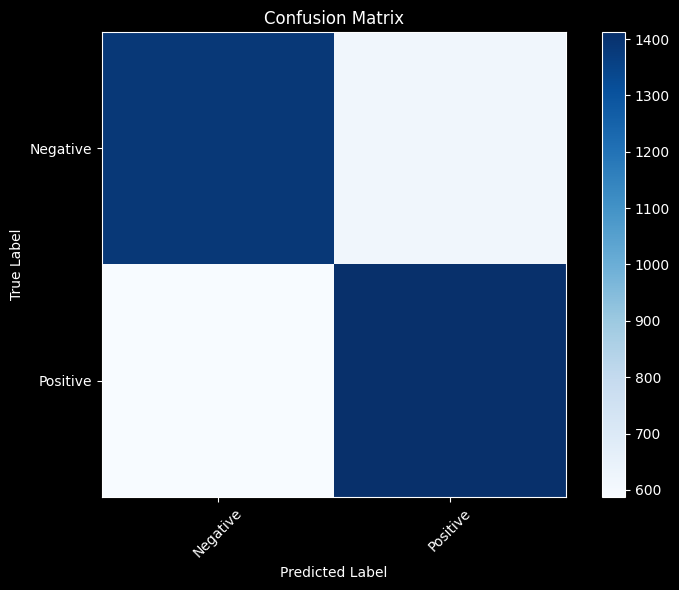

In [28]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix("Confusion Matrix", conf_mat, ['Negative', 'Positive'])

### Using text and not vectorization

In [30]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
valid_df = pd.read_csv('valid.csv')

In [32]:
# train_df = train_df[train_df['stars'].isin([1, 2, 4, 5])]
# train_df = train_df[train_df['language'].isin(['en', 'de', 'fr', 'es'])]
train_df = train_df[train_df['language'].isin(['en'])]

# test_df = test_df[test_df['stars'].isin([1, 2, 4, 5])]
# test_df = test_df[test_df['language'].isin(['en', 'de', 'fr', 'es'])]
test_df = test_df[test_df['language'].isin(['en'])]

# valid_df = valid_df[valid_df['stars'].isin([1, 2, 4, 5])]
# test_df = test_df[test_df['language'].isin(['en', 'de', 'fr', 'es'])]
valid_df = valid_df[valid_df['language'].isin(['en'])]


columns_to_drop = ['review_id', 'product_id', 'reviewer_id', 'product_category']
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)
valid_df.drop(columns=columns_to_drop, inplace=True)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

/var/folders/ld/rqglbq693g37vv4gt0w2w32c0000gp/T/ipykernel_39024/3925197843.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=columns_to_drop, inplace=True)


In [34]:
train_df = replace_mapping(train_df, 'stars')
test_df = replace_mapping(test_df, 'stars')
valid_df = replace_mapping(valid_df, 'stars')

In [35]:
train_df

,stars,review_body,review_title,language
0,0,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en
1,0,the cabinet dot were all detached from backing...,Not use able,en
2,0,I received my first order of this product and ...,The product is junk.,en
3,0,This product is a piece of shit. Do not buy. D...,Fucking waste of money,en
4,0,went through 3 in one day doesn't fit correct ...,bubble,en
...,...,...,...,...
199995,1,"Cute slippers, my MIL loved them.",Nice and fit as advertised,en
199996,1,My 6 year old likes this and keeps him engaged...,good to keep the kids engaged,en
199997,1,Replaced my battery with it. Works like new.,This works,en
199998,1,"I like them, holding up well.",Well made.,en


In [42]:
train_pool = Pool(
    train_df["review_body"],
    train_df["stars"].to_numpy(),
    text_features=["review_body", "review_title", "language"],
    cat_features=None
)
valid_pool = Pool(
    test_df["review_body"],
    test_df["stars"].to_numpy(),
    text_features=["review_body", "review_title", "language"],
    cat_features=None
)

catboost_params = {
    'iterations': 2000,
    'learning_rate': 0.01,
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 20,
    'use_best_model': True,
    'verbose': 50
}
# clas_weight = [5,4]
model = CatBoostClassifier(**catboost_params, loss_function='MultiClass', tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ])
model.fit(train_pool, eval_set=valid_pool)

CatBoostError: features parameter contains string value 'review_body' but feature names for a dataset are not specified